# 簡易テスト用のコード：

## TODO: 
 - [ ] データの読み込み
 - [ ] グラフの構築
 - [ ] 集約する頂点対の候補を取得する処理
 - [ ] 集約処理
 - [ ] グラフの描画

**迷ったらとりあえずデータを保存しておいて！**

# ライブラリのインポート + グローバル変数の宣言

In [1]:
import os
import pandas as pd
import seaborn as sns
import pickle
from package_v2.process_data_for_LP import main_merscope, main_xenium
from package_v2.viewer import Plot_Polygon_Viewer
from package_v2.process_merge_graph import transfer_to_celltype_df, create_graph, visualize_predicted_type, get_merge_candidates_list, save_results, process_merge_nodes

In [2]:

# グローバル変数の宣言
input_dir = "/work/datasets/Yahara/202304161129_MsFetusHumerus-23003-2-VS71-YS_VMSC07201/region_0"
output_dir="/work/output_MERSCOPE"
ref_dir = "/work/my_data/reference"
fov=236
width=2048
height=2048
z=3
reference_data_path="/work/datasets/reference/adata.h5ad"
num_x_bins, num_y_bins = 64, 64

lp_dir = f"/work/tmpout/merscope_{num_x_bins}x{num_y_bins}/LP_outputs"
md_path = os.path.join(lp_dir, "md.csv")
pd_path = os.path.join(lp_dir, "pd.csv")
lp_path = os.path.join(lp_dir, "x.csv")


# 既にあるデータの読み込み
md_df = pd.read_csv(md_path, index_col=["gene"])
pd_df = pd.read_csv(pd_path, index_col=["gene"])
lp_df = pd.read_csv(lp_path, index_col=["bin_x_y"])

ref_df_com, spe_df_com = main_merscope(ref_dir, input_dir, output_dir, fov, width, height, z, num_x_bins, num_y_bins, reference_data_path)

celltype_df = transfer_to_celltype_df(lp_df)

G = create_graph(num_x_bins, num_y_bins, celltype_df, pd_df, md_df)
G_init = G.copy()

Node:  4096  / Edge:  16002


In [3]:
# カテゴリ変数（ここでは細胞種）ごとに色を割り当てる辞書を作成する
categories = ref_df_com.columns.to_list()
type_counts = celltype_df['predicted_type'].value_counts().reindex(categories, fill_value=0).sort_values(ascending=False)
palette = sns.color_palette('hls', len(categories))
num_categories = len(categories)
step = 3 # num_categories と互いに素
shuffled_palette = [palette[i % num_categories] for i in range(0, num_categories * step, step)] 
sorted_categories = type_counts.index.tolist()
category_to_color = {category: shuffled_palette[i] for i, category in enumerate(sorted_categories)}

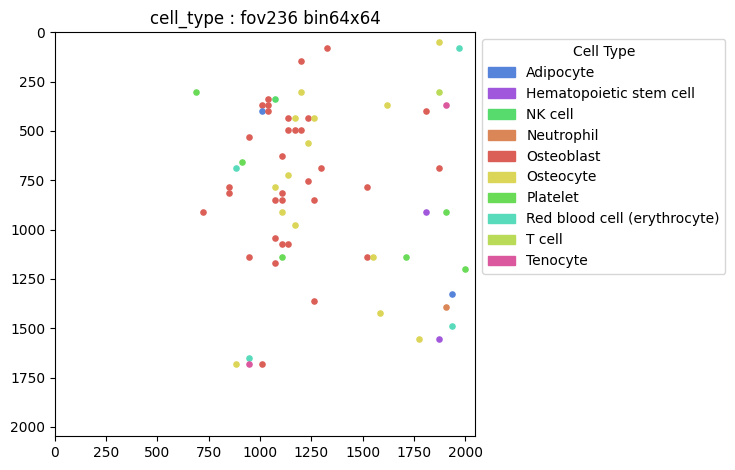

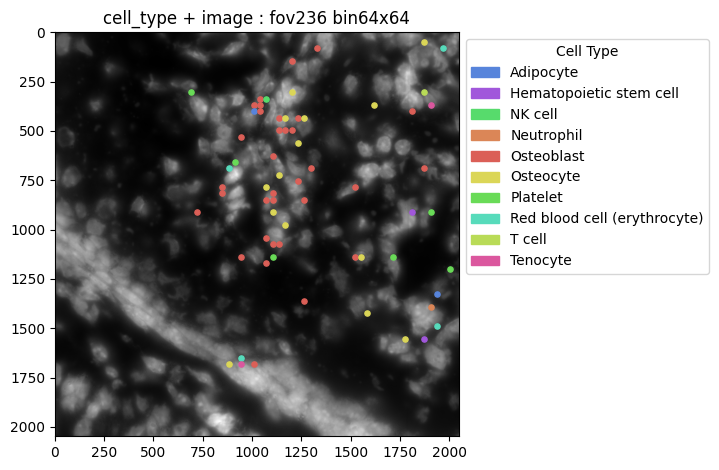

In [4]:
img_dir = os.path.join(output_dir, f"subset{fov}/images")
plotter1 = Plot_Polygon_Viewer(img_dir, fov, z, f"fov{fov} bin{num_x_bins}x{num_y_bins}", width, height)
visualize_predicted_type(G_init, num_x_bins, num_y_bins, category_to_color, False, plotter=plotter1)
visualize_predicted_type(G_init, num_x_bins, num_y_bins, category_to_color, True, plotter=plotter1)

In [5]:
def read_results(save_dir):
    x_merge_path = os.path.join(save_dir, "x_merge_df.pickle")
    pd_merge_path = os.path.join(save_dir, "pd_merge_df.pickle")
    md_merge_path = os.path.join(save_dir, "md_merge_df.pickle")
    list_merge_path = os.path.join(save_dir, "merge_candidates.pickle")

    with open(x_merge_path, mode='rb') as fi:
        x_merge_df = pickle.load(fi)

    with open(pd_merge_path, mode='rb') as fi:
        pd_merge_df = pickle.load(fi)

    with open(md_merge_path, mode='rb') as fi:
        md_merge_df = pickle.load(fi)

    with open(list_merge_path, mode='rb') as fi:
        merge_candidates = pickle.load(fi)
    
    return x_merge_df, pd_merge_df, md_merge_df, merge_candidates

save_dir = "/work/tmpout/0726_log"
x_merge_df, pd_merge_df, md_merge_df, merge_candidates = read_results(save_dir)

In [6]:
celltype_df_merge = transfer_to_celltype_df(x_merge_df)

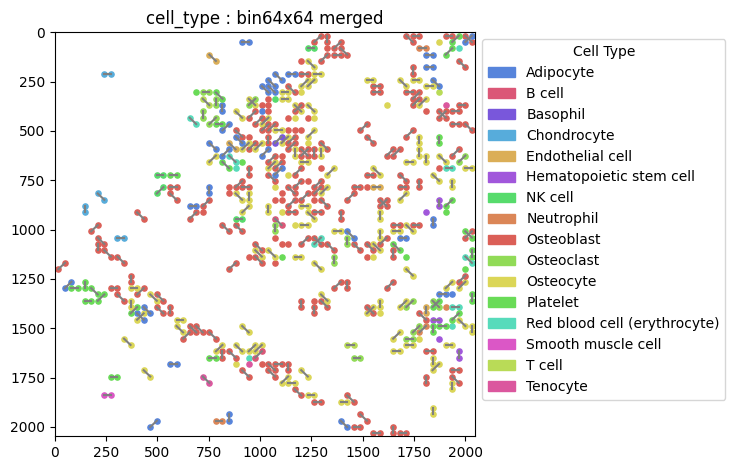

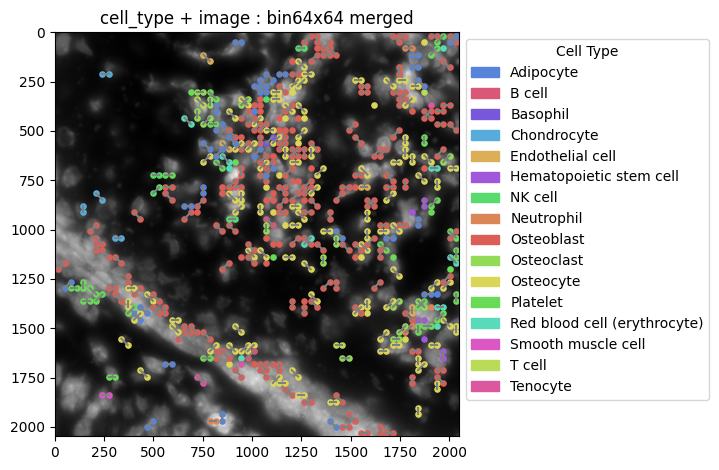

Node:  3772  / Edge:  14775


In [7]:
G = process_merge_nodes(G, merge_candidates, celltype_df_merge)
plotter2 = Plot_Polygon_Viewer(img_dir, fov, z, f"bin{num_x_bins}x{num_y_bins} merged", width, height)
visualize_predicted_type(G, num_x_bins, num_y_bins, category_to_color, False, plotter=plotter2)
visualize_predicted_type(G, num_x_bins, num_y_bins, category_to_color, True, plotter=plotter2)
print("Node: ", G.number_of_nodes(), " / Edge: ", G.number_of_edges())

In [8]:
G1 = G.copy()

In [14]:
import os
import pickle
from typing import Optional, List
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from package.myLP import my_LP_test
from package_v2.process_data_for_LP import main_merscope
from package_v2.viewer import Plot_Polygon_Viewer

def check_diff_area(node_name: str, pd_df: pd.DataFrame, md_df: pd.DataFrame) -> Optional[float]:
    if node_name not in pd_df.columns:
        return None
    return pd_df[node_name].sum() + md_df[node_name].sum()

def get_merge_spe(G, node:str, neighbor:str, spe_df_com:pd.DataFrame) -> pd.DataFrame:
    # 空間データの取得
    pos_list1 = G.nodes[node]["pos"]
    pos_list2 = G.nodes[neighbor]["pos"]

    # data1とdata2をリストに収集して一度に合計
    data1_list = [spe_df_com[f"{x}_{y}"] for (x, y) in pos_list1]
    data2_list = [spe_df_com[f"{x}_{y}"] for (x, y) in pos_list2]

    data1 = sum(data1_list)
    data2 = sum(data2_list)
    
    spe_merge = pd.DataFrame(data1 + data2, columns=[f"{node}_{neighbor}"])
    return spe_merge


def merge_dataframes(x_merge_df, pd_merge_df, md_merge_df, x_tmp, pd_tmp, md_tmp):
    if x_merge_df is None:
        return x_tmp.copy(), pd_tmp.copy(), md_tmp.copy()
    return (pd.concat([x_merge_df, x_tmp]),
            pd.concat([pd_merge_df, pd_tmp], axis=1),
            pd.concat([md_merge_df, md_tmp], axis=1))


def get_merge_candidates_list2(G:nx.Graph, pd_df, md_df, ref_df_com , spe_df_com, save_dir):
    checked_pair = set()
    merge_candidates = []
    x_merge_df, pd_merge_df, md_merge_df = None, None, None

    for node, data in tqdm(G.nodes(data=True)):
        """
        if data["cell_type"] != "Background":
            continue
            
        if any(G.nodes[neighbor]["cell_type"] != "Background" for neighbor in neighbors):
            continue
        
        """
        neighbors = list(nx.all_neighbors(G, node))
        diff1 = G.nodes[node]["diff"]

        for neighbor in neighbors:
            if (node, neighbor) in checked_pair or (neighbor, node) in checked_pair:
                continue
            checked_pair.add((node, neighbor))
            
            diff2 = G.nodes[neighbor]["diff"]
            diff_sum = diff1 + diff2
            
            name = f"{node}_{neighbor}"
            diff_merge = check_diff_area(name, pd_df, md_df)
            if diff_merge is None:
                spe_merge = get_merge_spe(G, node, neighbor, spe_df_com)
                x_tmp, pd_tmp, md_tmp = my_LP_test(ref_df_com, spe_merge, save_dir)
                x_merge_df, pd_merge_df, md_merge_df = merge_dataframes(x_merge_df, pd_merge_df, md_merge_df, x_tmp, pd_tmp, md_tmp)
                diff_merge = check_diff_area(name, pd_tmp, md_tmp)
        
            if diff_merge < diff_sum:
                merge_candidates.append((node, neighbor, diff_sum - diff_merge))
    return x_merge_df, pd_merge_df, md_merge_df, merge_candidates

In [16]:
save_dir = "0729_log_loop2"

pd_df_combined = pd.concat([pd_df, pd_merge_df], axis=1)
md_df_combined = pd.concat([md_df, md_merge_df], axis=1)

x_merge_df2, pd_merge_df2, md_merge_df2, merge_candidates2 = get_merge_candidates_list2(G, pd_df_combined, md_df_combined, ref_df_com , spe_df_com, save_dir)

100%|██████████| 3772/3772 [12:26<00:00,  5.05it/s]


In [17]:
save_results(save_dir, x_merge_df2, pd_merge_df2, md_merge_df2, merge_candidates2)
celltype_df_merge2 = transfer_to_celltype_df(x_merge_df2)

In [28]:
def merge_node(G, node1:str, node2:str, diff, celltype_df_merge):
    new_node = f"{node1}_{node2}"
    new_pos = G.nodes[node1]['pos'] + G.nodes[node2]['pos']
    try:
        new_type = celltype_df_merge.at[f"{node1}_{node2}", "predicted_type"]
    except KeyError:
        new_type = celltype_df_merge.at[f"{node2}_{node1}", "predicted_type"]

    # 新しい頂点の追加
    G.add_node(new_node, pos=new_pos, cell_type=new_type, diff=diff)

    # 隣接エッジの張り直し
    for neighbor in set(G.neighbors(node1)).union(set(G.neighbors(node2))):
        if neighbor != new_node:  # 自分自身にはエッジを張らない
            G.add_edge(new_node, neighbor, att="neighbor")
    
    # 元々の頂点とエッジの削除
    G.remove_node(node1)
    G.remove_node(node2)
    return new_node


def process_merge_nodes2(G:nx.Graph, merge_candidates:List, celltype_df_merge:pd.DataFrame):
    merge_candidates.sort(key=lambda x: x[2], reverse=True)
    
    merged_nodes = set()
    
    for node1, node2, diff in merge_candidates:
        if node1 in merged_nodes or node2 in merged_nodes:
            continue

        if node1 in G.nodes and node2 in G.nodes:
            new_node_name = merge_node(G, node1, node2, diff, celltype_df_merge)
            merged_nodes.add(new_node_name)
            merged_nodes.add(node1)
            merged_nodes.add(node2)

    return G
from package_v2.process_merge_graph import process_merge_nodes

G = G1.copy()
G = process_merge_nodes(G, merge_candidates2, celltype_df_merge2)

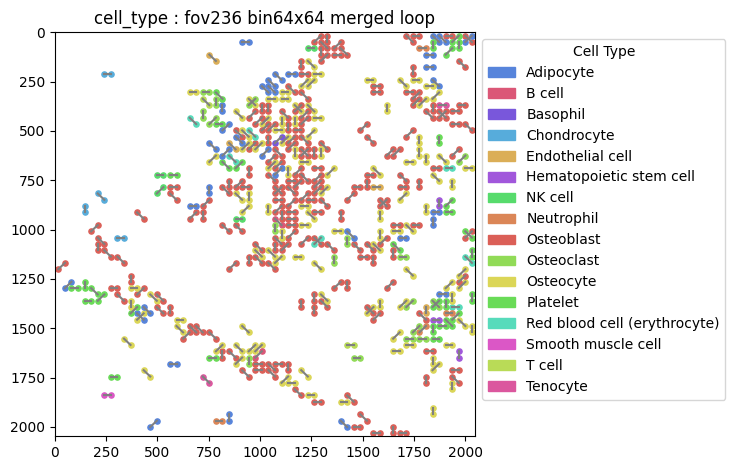

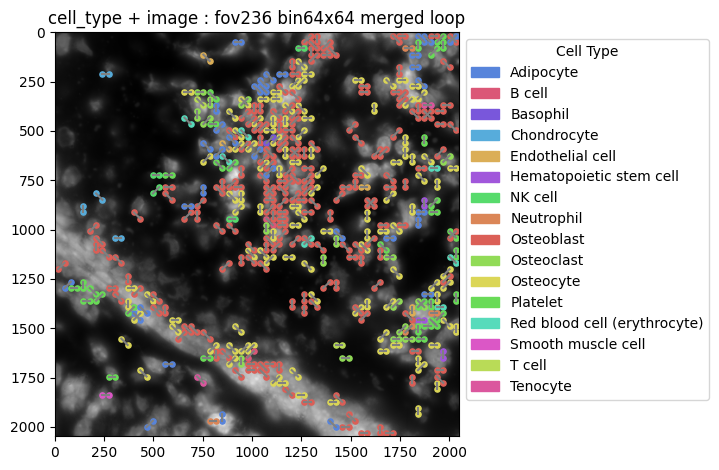

In [29]:
plotter3 = Plot_Polygon_Viewer(img_dir, fov, z, f"fov{fov} bin{num_x_bins}x{num_y_bins} merged loop", width, height)
visualize_predicted_type(G, num_x_bins, num_y_bins, category_to_color, False, plotter=plotter3)
visualize_predicted_type(G, num_x_bins, num_y_bins, category_to_color, True, plotter=plotter3)

In [30]:
print("Node: ", G.number_of_nodes(), " / Edge: ", G.number_of_edges())

Node:  3697  / Edge:  14460


In [ ]:
G2 = G.copy()